# Stacking rankers demo

In [1]:
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from rankers.Stacker import Stacker
from rankers.Ranker import Ranker
from Evaluations import get_evaluation_plots

In [2]:
#10 weeks in total for training, validation is done on last 5 weeks
#this is due to memory contstraints. Ideally, nr_validation_weeks would equal nr_training_weeks so validation scores represent abilities of ranker when trained.
nr_training_weeks = 10
nr_validation_weeks = 5

In [3]:
#loading testing and training data
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False, nr_training_weeks=nr_training_weeks)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


In [4]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [5]:
test_X = test

In [6]:
lgbm_ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=0
)

In [7]:
adaboost_ranker = Ranker(AdaBoostClassifier())

In [8]:
gnb_ranker = Ranker(GaussianNB())

### Metamodel (using AdaBoost ranker as metamodel)

In [9]:
stacker = Stacker([lgbm_ranker, gnb_ranker, adaboost_ranker], Ranker(AdaBoostClassifier()), use_groups=[True, False, False])

In [10]:
stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)

computing validation predictions for each of the base rankers...


training metamodel


/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...


In [11]:
#adding prediction column from metamodel predictions
test['ranker_meta_model'] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   8.   1. ]
 [ 2.   9.  13. ]
 [ 7.  10.   8. ]
 ...
 [ 7.   6.  10. ]
 [ 7.   2.   4. ]
 [12.5 12.  11. ]]


### Metamodel using AdaBoost Regressor as metamodel

In [12]:
stacker = Stacker([lgbm_ranker, gnb_ranker, adaboost_ranker], AdaBoostRegressor(), use_groups=[True, False, False])

In [13]:
stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)

computing validation predictions for each of the base rankers...


training metamodel


/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...


In [14]:
test['regressor_meta_model'] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Predicting with metamodel


Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   8.   1. ]
 [ 2.   9.  13. ]
 [ 7.  10.   8. ]
 ...
 [ 7.   6.  10. ]
 [ 7.   2.   4. ]
 [12.5 12.  11. ]]


### Weighted rank aggregation (no metamodel)

In [17]:
#predicting with rankers, unweighted (all rankers considered equally)
test['unweighted'] = stacker.predict(test_X, columns_to_use, weighting=None)

Predicting with None weighting


In [18]:
#predictions using MRR scores for weighting when rank averaging
test['MRR_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MRR")

Predicting with MRR weighting


In [19]:
#predictions using MAP@12 scores for weighting when rank averaging
test['MAPk_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MAPk")

Predicting with MAPk weighting


Base rankers already fit to data by stacker, so can just call predict to get their predictions

In [20]:
test['lgbm'] = lgbm_ranker.predict(test_X[columns_to_use])

In [21]:
test['adaboost'] = adaboost_ranker.predict(test_X[columns_to_use])

In [22]:
test['naive_bayes'] = gnb_ranker.predict(test_X[columns_to_use])

In [23]:
pred_cols = ['unweighted', 'MRR_weighted', 'MAPk_weighted', 'lgbm', 'adaboost', 'naive_bayes', 'ranker_meta_model', 'regressor_meta_model']

In [24]:
#sanity check to make sure metamodel methods are computing different scores. (actual "rank" values are implicit and are the item's index in the list when ordered later)
test[["ranker_meta_model", "regressor_meta_model"]].head(30)

,ranker_meta_model,regressor_meta_model
11557594,6326372.0,0.776584
11557595,4903627.5,0.624328
11557596,2916210.5,0.049626
11557597,4639534.0,0.584228
11557598,5319419.5,0.225957
11557599,5174161.5,0.049626
11557600,4485510.5,0.049626
11557601,3114003.5,0.049626
11557602,4739272.5,0.049626
11557603,878245.0,0.049626


In [25]:
#sanity check to make sure weights are computed. Weights make intuative sense (weights 0 and 2 are fairly similar and high - LGBM and AdaBoost rankers are fairly good and produce similar scores,
#weights 1 are lower - Gaussian Naive Bayes is lower score because ranker performs worse)
stacker.ranker_weights

{'MRR': [0.9347483118683491, 0.6897846467682945, 0.9003159348981736],
 'MAPk': [0.8737509332620338, 0.502596190746297, 0.8288666352635037]}

Evaluation for unweighted
####################

MAP@12 (all customers):             0.0011028280432373943
MAP@12 (only purchasing customers): 0.021933463103920338

MRR (all customers):                0.00210979268079226
MRR (only purchasing customers):    0.04196035837575908



Evaluation for MRR_weighted
####################

MAP@12 (all customers):             0.0011061457203811861
MAP@12 (only purchasing customers): 0.021999446327388664

MRR (all customers):                0.002113270002105846
MRR (only purchasing customers):    0.04202951666312737



Evaluation for MAPk_weighted
####################

MAP@12 (all customers):             0.0011132908008257359
MAP@12 (only purchasing customers): 0.022141550401787273

MRR (all customers):                0.002122842095035577
MRR (only purchasing customers):    0.042219890083887726



Evaluation for lgbm
####################

MAP@12 (all customers):             0.0011825299209288645
MAP@12 (only purchasing customers): 0.02351860432732203

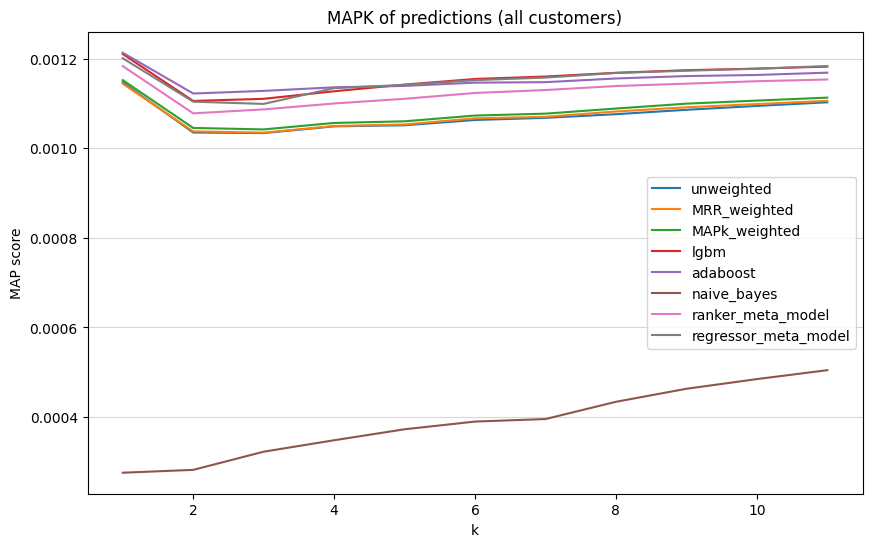

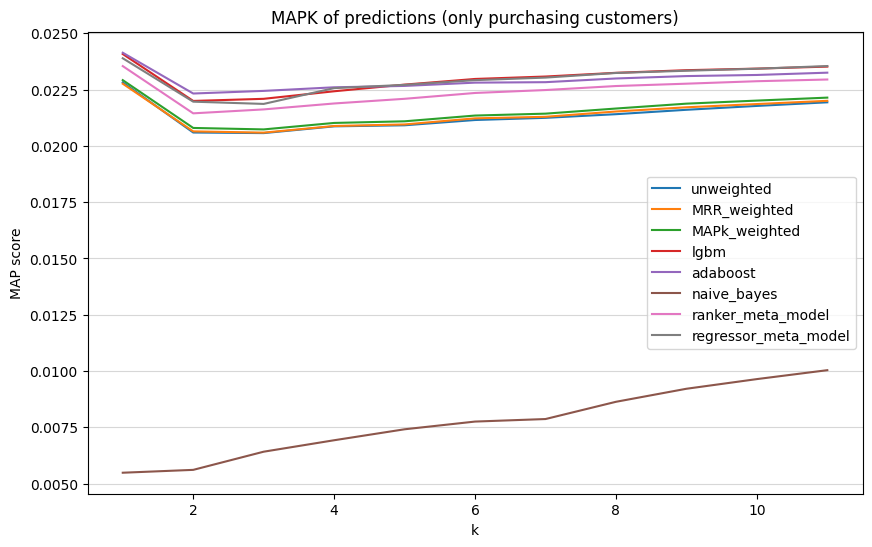

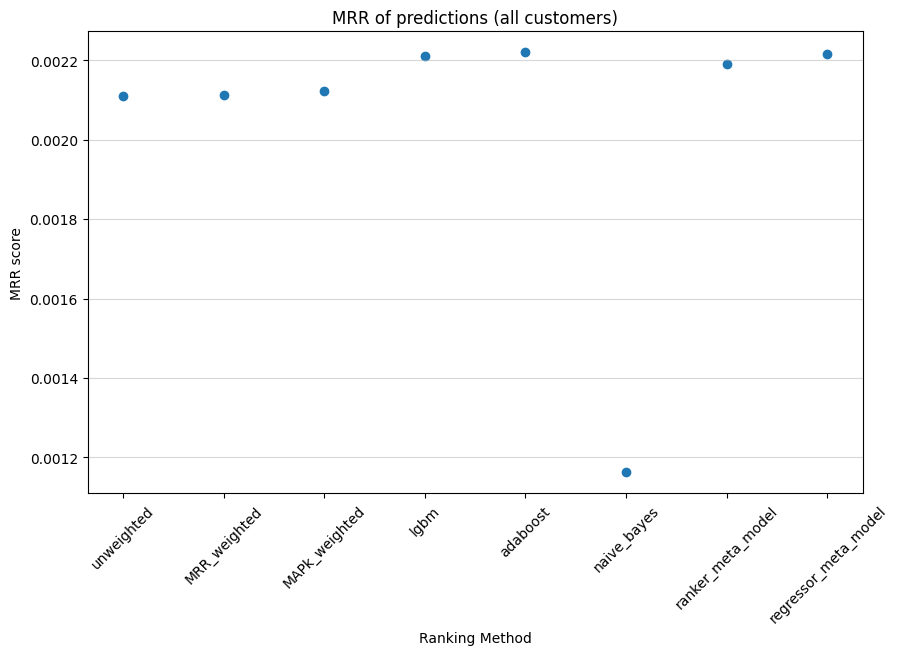

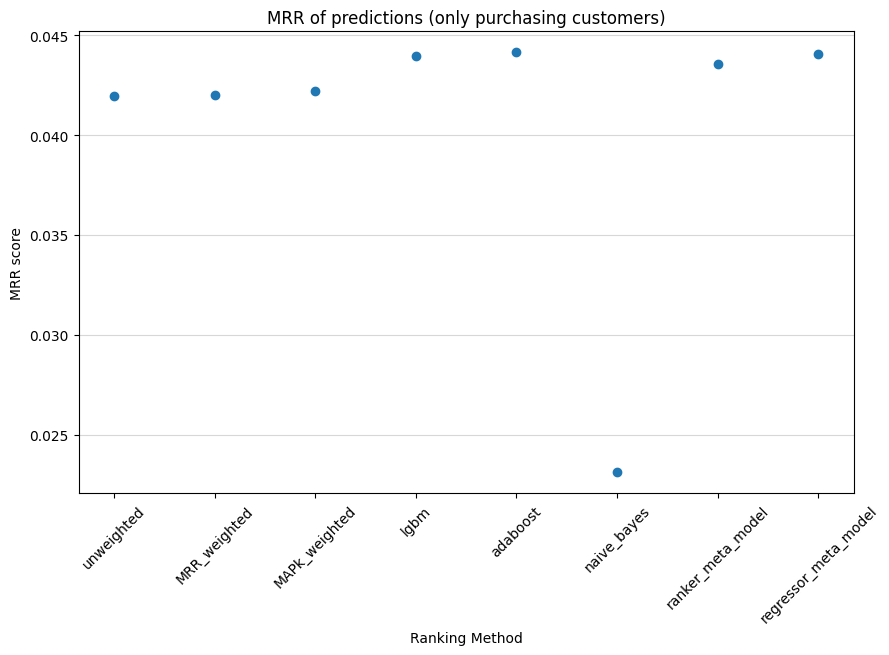

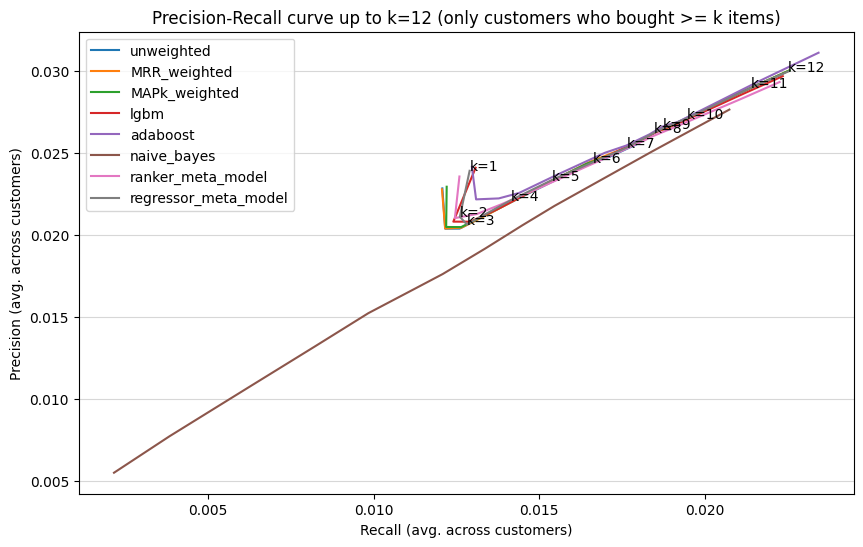

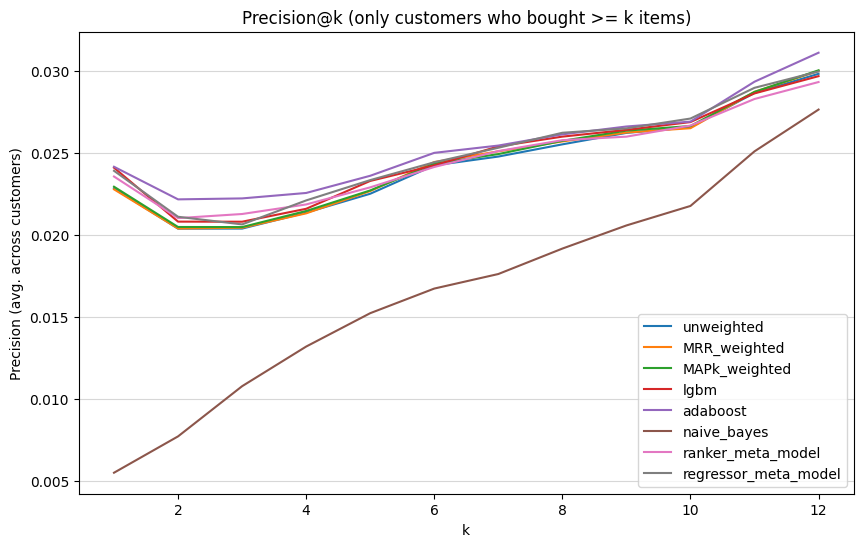

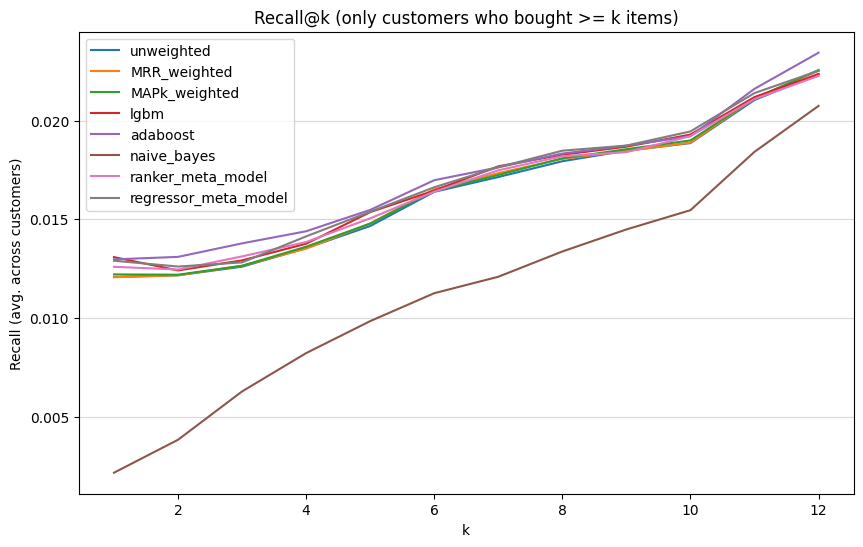

({'unweighted': [0.0011472470444175572,
   0.0010353649470108894,
   0.0010340489252353869,
   0.0010491477442981841,
   0.001051505042995444,
   0.0010632909290870778,
   0.0010681564909135908,
   0.0010762769547290824,
   0.0010861066210504913,
   0.0010947488283903225,
   0.0011028280432373943],
  'MRR_weighted': [0.0011443315500225951,
   0.001037916004606481,
   0.001035081496166935,
   0.0010499272341190588,
   0.0010533717692677743,
   0.0010670118288086483,
   0.0010704761683290103,
   0.0010822968122704902,
   0.0010916963612185684,
   0.0010989325688154459,
   0.0011061457203811861],
  'MAPk_weighted': [0.0011523491596087407,
   0.0010455691773932564,
   0.001042289246198924,
   0.0010567452392406113,
   0.0010604011477329599,
   0.0010732483547703153,
   0.0010774852837775975,
   0.001088922494341644,
   0.0010998145790970194,
   0.0011066558901768522,
   0.0011132908008257359],
  'lgbm': [0.0012106590475079813,
   0.0011058834676890333,
   0.0011106211460808466,
   0.001127

In [26]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)

Regressor metamodel scores well, similarly to LGBM ranker. Ranker metamodel perfoms slightly worse. Maybe the regressor metamodel's score is restricted because it is also considering the GNB ranker which gives a low score. Will now test without the GNB base ranker to see if the stacker score will improve without a poor ranker. 

### Retraining regressor (and weighted rank aggregation) stacker without Naive Bayes ranker

In [27]:
#removing the GNB information for retraining without it
del stacker.rankers[1]
for key, weights in stacker.ranker_weights.items():
    del weights[1]
del stacker.use_groups[1]

In [28]:
stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)

computing validation predictions for each of the base rankers...


training metamodel


/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 2)
Computing scores on validatation...
retraining base rankers on full training set...


In [30]:
test['regressor_meta_model'] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Predicting with metamodel
Prediction matrix shape: (6658206, 2)
prediction matrix:
[[ 1.   1. ]
 [ 2.  13. ]
 [ 7.   8. ]
 ...
 [ 7.  10. ]
 [ 7.   4. ]
 [12.5 11. ]]


In [31]:
test['MRR_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MRR")

Predicting with MRR weighting


In [32]:
test['MAPk_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MAPk")

Predicting with MAPk weighting


In [33]:
test['lgbm'] = lgbm_ranker.predict(test_X[columns_to_use])

In [34]:
test['adaboost'] = adaboost_ranker.predict(test_X[columns_to_use])

In [35]:
pred_cols = ['unweighted', 'MRR_weighted', 'MAPk_weighted', 'lgbm', 'adaboost', 'regressor_meta_model']

In [36]:
#sanity check - now only weights for LGBM and AdaBoost rankers are present
stacker.ranker_weights

{'MRR': [0.9347483118683491, 0.9003159348981736],
 'MAPk': [0.8737509332620338, 0.8288666352635037]}

Evaluation for unweighted
####################

MAP@12 (all customers):             0.0011028280432373943
MAP@12 (only purchasing customers): 0.021933463103920338

MRR (all customers):                0.00210979268079226
MRR (only purchasing customers):    0.04196035837575908



Evaluation for MRR_weighted
####################

MAP@12 (all customers):             0.0011788403502119389
MAP@12 (only purchasing customers): 0.023445224743183588

MRR (all customers):                0.0022320797906447898
MRR (only purchasing customers):    0.04439245087511363



Evaluation for MAPk_weighted
####################

MAP@12 (all customers):             0.001179170433715611
MAP@12 (only purchasing customers): 0.02345178956930802

MRR (all customers):                0.0022326024655869173
MRR (only purchasing customers):    0.04440284603293428



Evaluation for lgbm
####################

MAP@12 (all customers):             0.0011825299209288645
MAP@12 (only purchasing customers): 0.023518604327322033

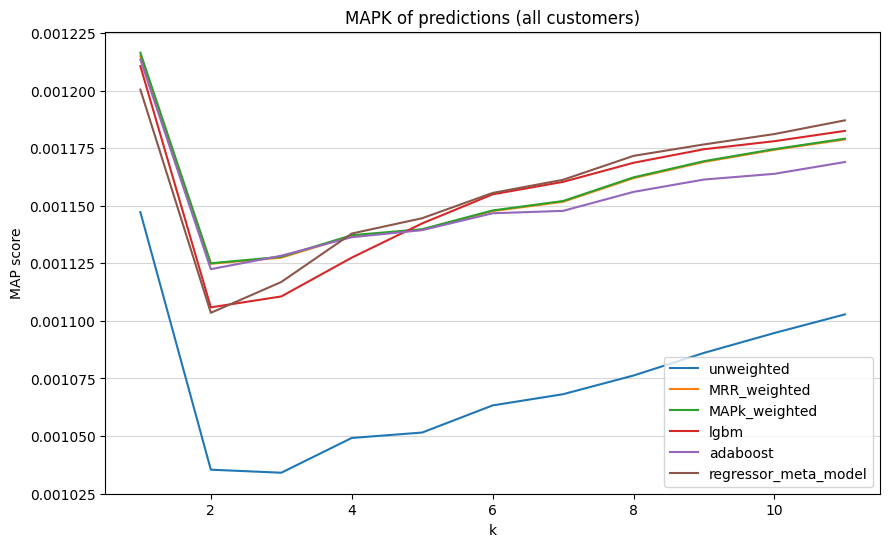

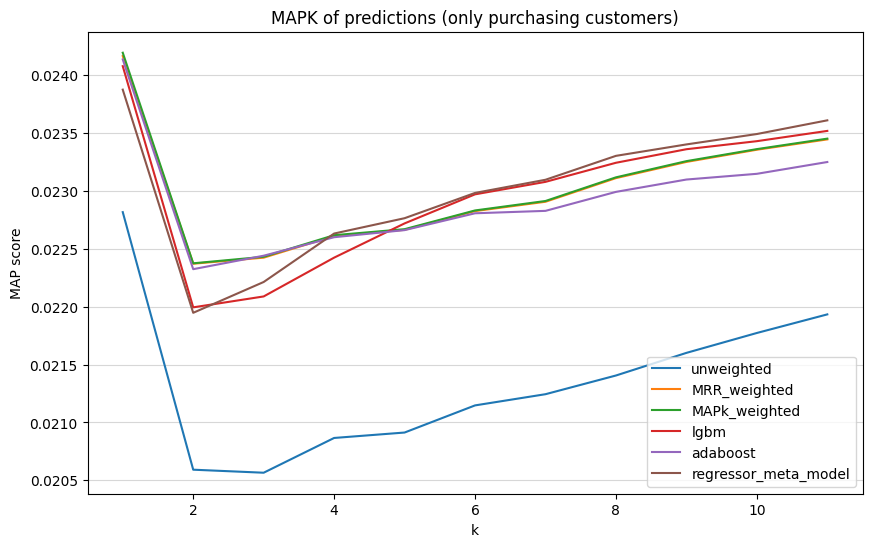

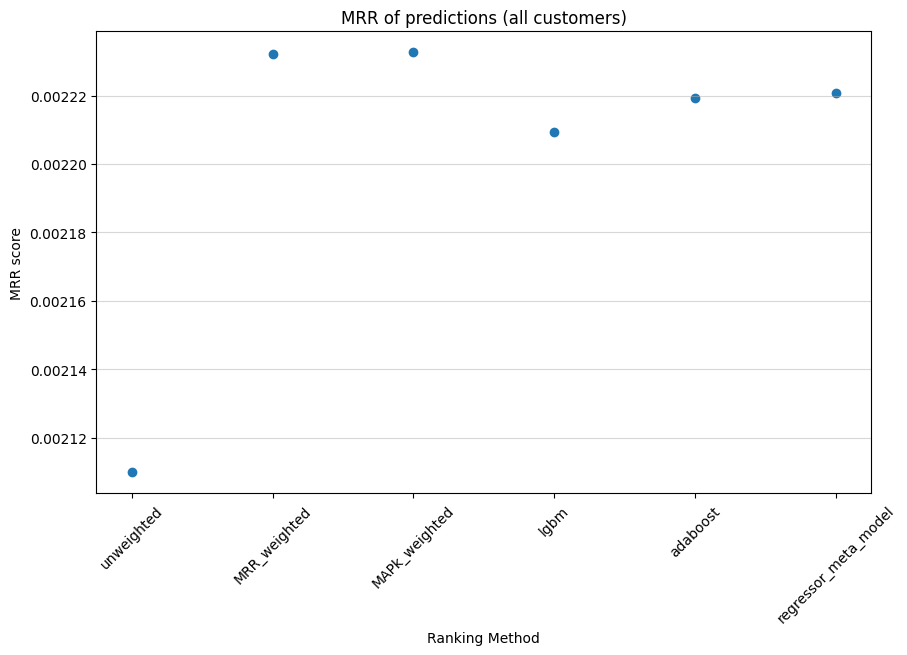

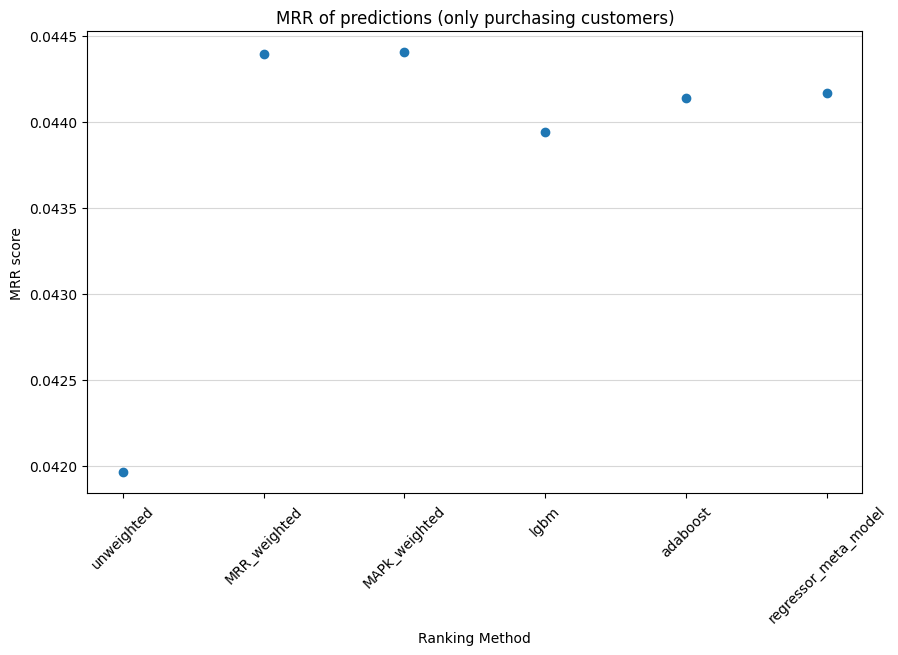

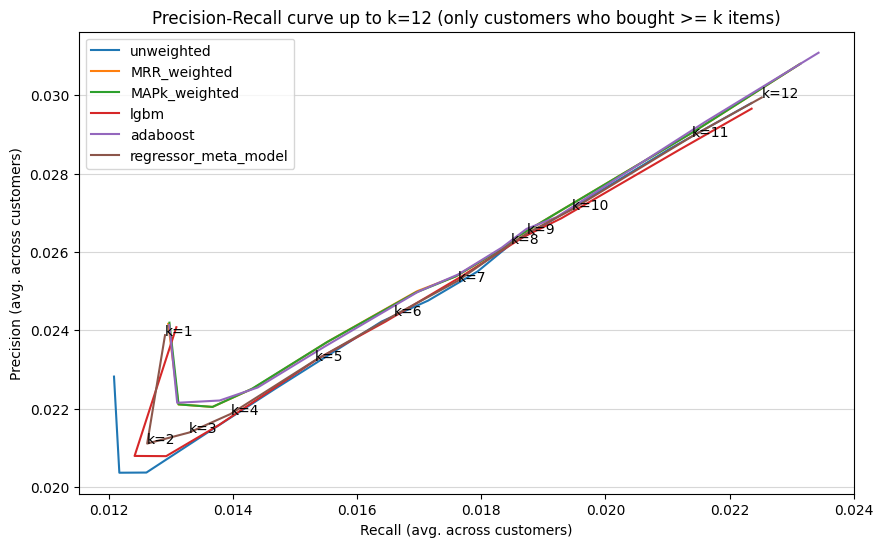

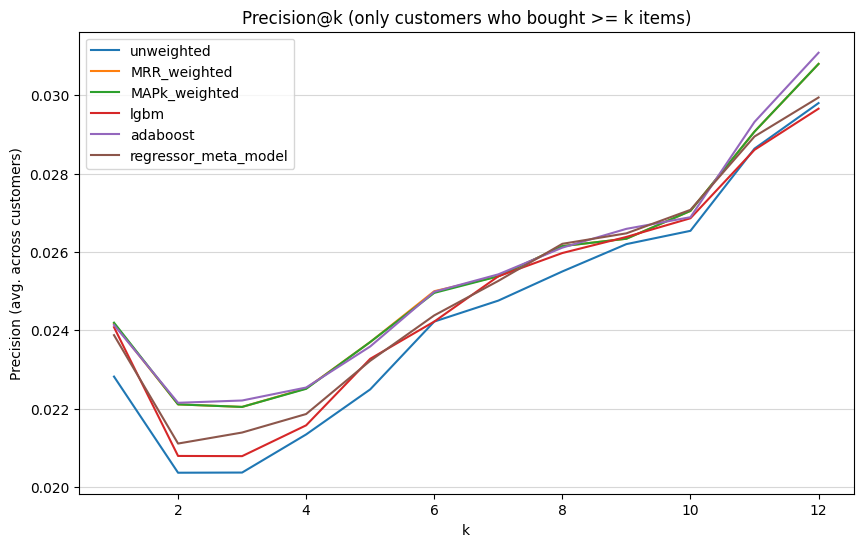

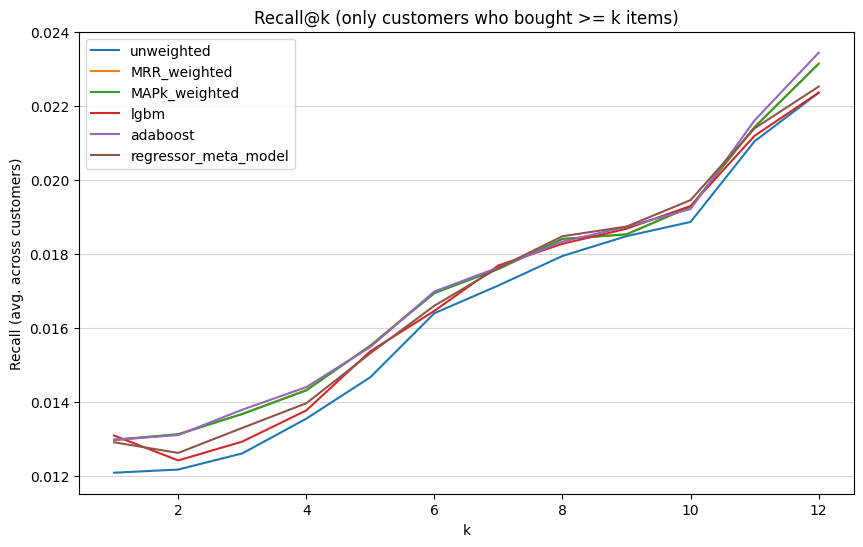

({'unweighted': [0.0011472470444175572,
   0.0010353649470108894,
   0.0010340489252353869,
   0.0010491477442981841,
   0.001051505042995444,
   0.0010632909290870778,
   0.0010681564909135908,
   0.0010762769547290824,
   0.0010861066210504913,
   0.0010947488283903225,
   0.0011028280432373943],
  'MRR_weighted': [0.0012150322891004242,
   0.0011248341812562866,
   0.0011274662248072938,
   0.0011368859037465715,
   0.001139554795907294,
   0.001147693074567008,
   0.0011517461324000045,
   0.001162018353797493,
   0.0011690507387055872,
   0.0011743542068352872,
   0.0011788403502119389],
  'MAPk_weighted': [0.0012164900362979052,
   0.0011250163996559717,
   0.001127850908095518,
   0.0011372250324348744,
   0.0011398374368916946,
   0.0011479745007620772,
   0.001152080819256569,
   0.0011623539393502463,
   0.001169386782214636,
   0.0011746177293494985,
   0.001179170433715611],
  'lgbm': [0.0012106590475079813,
   0.0011058834676890333,
   0.0011106211460808466,
   0.001127476

In [37]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)

There is now a larger difference between stacker with regressor model and the other rankers. Removing the poor-performing ranker seems to have improved the scores. Kaggle scores, however, show that similar scores are given with and without GNB as a base ranker.